# Continuous Control

---

This notebook uses the unity ML environment and trains a Deep Deterministic Policy Gradient (DDPG) agent to solve the Reacher environment.

DDPG is an actor-critic method closely related to a Deep Q-Network (DQN). Sometimes called an approximate DQN, a DDPQ learns a function that chooses the action that maximizes the Q-values of the next state, similar to a DQN.

First, the modules needed for the project are loaded.

In [1]:
# Import common/pip libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import deque
from unityagents import UnityEnvironment

# Import custom modules
from td3_agent import Agent
from model import Actor, Critic

If you want to use a GPU, make sure torch is running correctly. Otherwise, skip this step.

In [2]:
# torch gpu compatibility test
print(torch.cuda.is_available()==True,
torch.cuda.device_count()==1,
torch.cuda.current_device()==0,
torch.cuda.device(0),
torch.cuda.get_device_name(0))

True True True <torch.cuda.device object at 0x000001CD0E1654A8> NVIDIA GeForce RTX 3080 Laptop GPU


Select device to run for training.

In [3]:
# Uncomment the device you want to use.
#device = 'cuda:0'
device = 'cpu'

### 1. Start the Environment

If the python environment specifications are correct, then this cell should return no error. Otherwise, reference the project README and env.txt to ensure you have all the necessary packages. If the errors persist, try building an environment straight from the env.txt using `pip install -r env.txt`.

If the unity environment fails to load, make sure you have the `Reacher_Data` folder in the same directory as this notebook. Also verify the version number of the `unityagents` package (0.4.0) and try using version 3.6.3 of `python`.

If you want to train the agent and don't want to see it do anything, comment out line 2 in the cell below.

In [4]:
unity_env = UnityEnvironment(file_name='Reacher.exe'
                       ,no_graphics=True
                       )

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = unity_env.brain_names[0]
brain = unity_env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = unity_env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. (Optional) Take Random Actions in the Environment

Run the following code block to see what it looks like when the agent behaves randomly.

In [7]:
# Run a random agent
env_info = unity_env.reset(train_mode=False)[brain_name]     # reset the environment
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = unity_env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


Don't worry about where the agent is after the random actions. The environment will reset before we begin training.

### Train the Agent

The following cell trains the agent using the DDPG architecture described in `report.md`.

In [7]:
# Initialize the agent.
agent = Agent(state_size=env_info.vector_observations.shape[1], action_size=action_size,
              actor=Actor, critic=Critic, device=device)

Episode 100	Average Score: 3.92
Episode 200	Average Score: 10.34
Episode 300	Average Score: 15.24
Episode 400	Average Score: 22.24
Episode 491	Average Score: 30.18
Environment solved in 391 episodes!	Average Score: 30.18


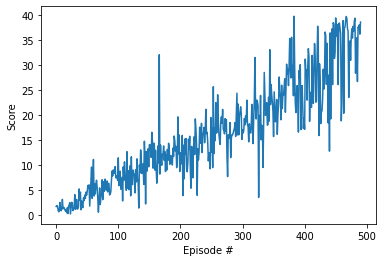

<Figure size 432x288 with 0 Axes>

In [8]:
class Env(object):
    """
    Helper Class for translating Unity env to gym env.
    """
    def __init__(self, unity_env, train_mode=True):
        """Constructor for environment helper class.

        Params
        ======
            unity_env (object): unity environment object
            train_mode (bool): start the unity environment in training mode
        """
        self.env = unity_env
        self.brain_name = self.env.brain_names[0]
        self.brain = self.env.brains[self.brain_name]
        self.action_size = self.brain.vector_action_space_size
        self.env_info = self.env.reset(train_mode=train_mode)[self.brain_name]
        self.state_size = len(self.env_info.vector_observations[0])
        self.train_mode = train_mode

    def reset(self):
        """Reset the unity environment state
        """
        self.env_info = self.env.reset(train_mode=self.train_mode)[self.brain_name]
        return self.env_info.vector_observations[0]

    def step(self, action):
        """Take a step in the unity environment.

        Params
        ======
            action (int): action selected by agent
        """
        self.env_info = self.env.step(action)[self.brain_name]        # send the action to the environment
        next_state = self.env_info.vector_observations[0]   # get the next state
        reward = self.env_info.rewards[0]                   # get the reward
        done = self.env_info.local_done[0]
        return next_state, reward, done, None


env = Env(unity_env)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def td3(n_episodes=2000, max_t=1000, target_score=200):
    """Run a TD3 training loop.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        target_score (float): stop the training early if the average score over a window
                              is higher than target_score
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action.cpu().data.numpy())
            agent.step(state, action.cpu().data.numpy(), reward, next_state, done, t)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)       # save most recent score for early stopping
        scores.append(score)              # save most recent score for recording all scores
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=target_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            agent.save()
            break

    return scores

# Begin training
scores = td3(n_episodes=2000, target_score=30.0)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
plt.savefig('avg_reward.png')

### Evaluate

As shown previously, the agent solves the environment in ~400 episodes. If you have the unity window open and enabled in the environment, then you can run the cell below to watch your trained agent.

In [ ]:
# load the weights from file
agent.actor_local.load_state_dict(torch.load('actor_checkpoint.pth'))

# Observe trained agent
env_info = unity_env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)        # select an action
    env_info = unity_env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

Don't forget to close the environment when you're done.

In [ ]:
# close environment
unity_env.close()